# Sentiment Analysis On Movie Reviews - Naive Bayes Approach
## CS251/CS340 - Machine Learning
Anzhel Torosyan

Melanya Khachatryan

Narek Mikayelyan

[Dataset can be assessed here.](https://drive.google.com/file/d/1DGcoHEf6sYfsc8n4vvKlVj9N6ZUkbdfF/view?usp=drive_link) It's a balanced version of the 25k Positive and 25k Negative Sets. There's also an additional 50k unlabeled dataset for unsupervised learning purposes which we're not going to use ([Stanford AI Lab Dataset](https://ai.stanford.edu/~amaas/data/sentiment/)).

## Data processing

In [1]:
!pip install tweet-preprocessor
!pip install emoji
!pip install pyspellchecker
!pip install textblob

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import emoji
import re
import seaborn as sns
import string
import preprocessor as p
import spellchecker
import time


import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from tqdm import tqdm
from bs4 import BeautifulSoup
from textblob import TextBlob
from spellchecker import SpellChecker
from collections import defaultdict
from scipy.sparse import csr_matrix
from scipy.linalg import svd

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


First we load the dataset and then clean it.

To clean them, we remove mentions, URLs, hashtags, convert them all to lowercase and convert the emojis to text. We could also remove contractions and correct misspelled words.

In [3]:
data = pd.read_csv('IMDB_Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


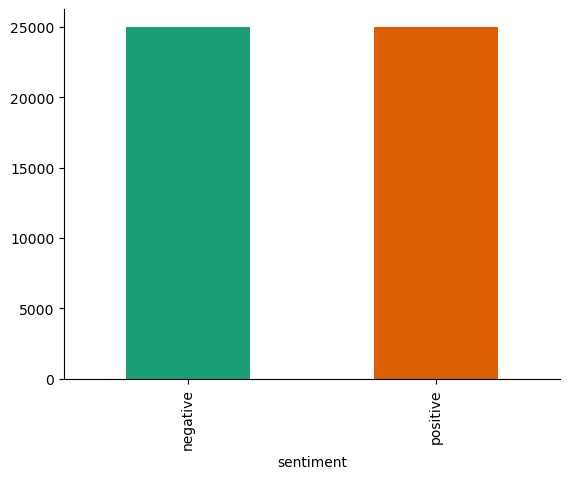

In [4]:
#data.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
#plt.gca().spines[['top', 'right',]].set_visible(False)

data.groupby('sentiment').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)

In [5]:
# Map sentiment labels to numerical values and update the 'sentiment' column in the DataFrame accordingly.

values = {
    'positive': 1,
    'negative': 0
}

data['sentiment'] = data['sentiment'].apply(lambda x: values[x])

data

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


- Removing mentions, URLs and hashtags

In [6]:
data['review'] = data['review'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())

# This will remove mentions, URLs, and hashtags, we use p.clean(<text>) for that purpose
p.set_options(p.OPT.MENTION, p.OPT.URL, p.OPT.HASHTAG)

# Remove data that is empty.
data = data[data['review'] != '']

data

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


- Making the Text Lowercase,  Removing HTML tags, Handling Emojis, Removing Punctuation

In [7]:
# Defining the function clean_text which is going to help us process the text
def clean_text(text: str):
    # Converting text to lowercase
    new_text = text.lower()

    # Removing HTML tags
    new_text = p.clean(new_text)

    # Converting emojis to text and spliting the text into words
    new_text = emoji.demojize(new_text).split(' ')

    # Removing punctuation
    new_text = [''.join(c for c in word if c not in string.punctuation) for word in new_text]

    return ' '.join([w for w in new_text])

# Applying the clean_text function to the 'review' column of the DataFrame
data['review'] = data['review'].apply(clean_text)

# Displaying the first 10 rows of the DataFrame
print(data[:10])

                                              review  sentiment
0  one of the other reviewers has mentioned that ...          1
1  a wonderful little production the filming tech...          1
2  i thought this was a wonderful way to spend ti...          1
3  basically theres a family where a little boy j...          0
4  petter matteis love in the time of money is a ...          1
5  probably my alltime favorite movie a story of ...          1
6  i sure would like to see a resurrection of a u...          1
7  this show was an amazing fresh  innovative ide...          0
8  encouraged by the positive comments about this...          0
9  if you like original gut wrenching laughter yo...          1


- Tokenizing the Text,  Removing Stop Words, Performing Stemming, Correcting the Spelling Errors

In [8]:
# Method to remove stop words and tokenize the text
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

# Applying the clean_text function to the 'review' column of the DataFrame
data['review'] = data['review'].apply(remove_stopwords)

# Displaying the first 10 rows of the DataFrame
print(data[:10])

                                              review  sentiment
0  one reviewers mentioned watching 1 oz episode ...          1
1  wonderful little production filming technique ...          1
2  thought wonderful way spend time hot summer we...          1
3  basically theres family little boy jake thinks...          0
4  petter matteis love time money visually stunni...          1
5  probably alltime favorite movie story selfless...          1
6  sure would like see resurrection dated seahunt...          1
7  show amazing fresh innovative idea 70s first a...          0
8  encouraged positive comments film looking forw...          0
9  like original gut wrenching laughter like movi...          1


We wanted to check the spelling of the words as well, but our dataset is huge and if there are, let's say, 20 words per review on average (in fact there are even more), the algorithm needs to check the spelling of a million words which is time consuming. As far as we can tell this code snippet is runnable, it just didn't reach its destination in the 30 minutes that it was running.

In [9]:
# # Initializing the spell checker
# spell = spellchecker.SpellChecker(language='en')

# # Method to perform spelling correction
# def correct_spelling(text):
#     corrected_words = [spell.correction(word) if spell.correction(word) else word for word in text.split()]
#     corrected_text = ' '.join(corrected_words)
#     return corrected_text

# # Applying the clean_text function to the 'review' column of the DataFrame
# data['review'] = data['review'].apply(correct_spelling)

# # Displaying the first 10 rows of the DataFrame
# print(data[:10])

Stemming works awfully in our case (technically it worked awfully in every case we could manage to find online), that's why we are not going to consider it at all.

In [10]:
# # Method to perform stemming
# def stem_text(series):
#     stemmer = PorterStemmer()
#     if isinstance(series, str):
#         stemmed_tokens = [stemmer.stem(word) for word in series.split()]
#     else:
#         stemmed_tokens = [stemmer.stem(word) for word in series]
#     return ' '.join(stemmed_tokens)

# # Applying the clean_text function to the 'review' column of the DataFrame
# data['review'] = data['review'].apply(stem_text)

# # Displaying the first 10 rows of the DataFrame
# print(data[:10])

 Encoding categorical labels using LabelEncoder and extracting features and labels from our data.

In [11]:
encoder = LabelEncoder()
y = data['sentiment'] #extracts the 'sentiment' column from the DataFrame data and assigns it to the variable y.
# This assumes that the 'sentiment' column contains the categorical labels representing the sentiment of each sample (e.g., positive, negative).

X = data.iloc[:,0:1] # extracts the features from the DataFrame data. It selects all rows and the first column of the DataFrame.
# This assumes that the feature data is located in the first column.

In [12]:
X, y # X is a matrix, y is a vector

(                                                  review
 0      one reviewers mentioned watching 1 oz episode ...
 1      wonderful little production filming technique ...
 2      thought wonderful way spend time hot summer we...
 3      basically theres family little boy jake thinks...
 4      petter matteis love time money visually stunni...
 ...                                                  ...
 49995  thought movie right good job wasnt creative or...
 49996  bad plot bad dialogue bad acting idiotic direc...
 49997  catholic taught parochial elementary schools n...
 49998  im going disagree previous comment side maltin...
 49999  one expects star trek movies high art fans exp...
 
 [50000 rows x 1 columns],
 0        1
 1        1
 2        1
 3        0
 4        1
         ..
 49995    1
 49996    0
 49997    0
 49998    0
 49999    0
 Name: sentiment, Length: 50000, dtype: int64)

**Splitting the dataset into training and testing sets**

In [13]:
# This line splits the dataset into training and testing sets. X contains the features, and y contains the target variable.
# The data is split into training and testing sets with a ratio of 80:20 (test_size=0.2).
# The random_state=42 ensures reproducibility of the split.

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [14]:
X_train.shape

(40000, 1)

In [15]:
X_test.shape

(10000, 1)

In [16]:
y_train.shape

(40000,)

In [17]:
y_test.shape

(10000,)

**Bag of words is used for vectorization**

In [18]:
cv = CountVectorizer(min_df=300)
X_train_bow=cv.fit_transform(X_train['review'])
X_test_bow=cv.transform(X_test['review'])
print("Shape of X_train_bow:", X_train_bow.shape)
print("Shape of X_test_bow:", X_test_bow.shape)
X_train_bow

Shape of X_train_bow: (40000, 2091)
Shape of X_test_bow: (10000, 2091)


<40000x2091 sparse matrix of type '<class 'numpy.int64'>'
	with 2590912 stored elements in Compressed Sparse Row format>

It's generally not recommended to fit the CountVectorizer to the test data separately. The reason is that doing so can introduce a bias in the model evaluation process.

When we fit the CountVectorizer to the test data, we're essentially allowing information from the test set to leak into our model training process. This can lead to overfitting and inaccurate estimates of model performance.

Instead, the CountVectorizer should only be fitted to the training data. This ensures that the model is learning the vocabulary solely from the training set and generalizing to unseen data during the testing phase.

## Naive Bayes Implementation - NB with BOW

In [19]:
class NaiveBayes:
    def __init__(self, param=1):
        self.prior = {}
        self.class_conditional = defaultdict(lambda: defaultdict(int))
        self.param = param

    def train(self, X_train_bow, y_train):
        total_samples = len(y_train)
        
        # Calculate prior probabilities
        for label in set(y_train):
            self.prior[label] = (np.sum(y_train == label) + self.param) / (total_samples + 2 * self.param)
        
        # Calculate class conditional probabilities
        for i in range(X_train_bow.shape[0]):
            for word_index in range(X_train_bow.shape[-1]):
                self.class_conditional[word_index][y_train.iloc[i]] += X_train_bow[i, word_index]

    def posterior(self, X_test_bow):
        y_pred = []
        for x in X_test_bow:
            # Initializing posterior with prior probabilities
            probabilities = {label: np.log(self.prior[label]) for label in self.prior}
            for word_index in x.indices:
                for label in self.prior:
                    probabilities[label] += np.log((self.class_conditional[word_index][label] + self.param) /
                                                    (sum(self.class_conditional[word_index].values()) +
                                                     len(self.class_conditional) * self.param))
            y_pred.append(max(probabilities, key=probabilities.get))
        return y_pred


In [20]:
# X_train_bow2 = X_train_bow[:100]
# y_train2 = y_train[:100]
# X_test_bow2 = X_test_bow[:100]
# y_test2 = y_test[:100]

X_train_bow2 = X_train_bow
y_train2 = y_train
X_test_bow2 = X_test_bow
y_test2 = y_test

In [21]:
# Instantiate the NaiveBayes classifier
nb = NaiveBayes(param=1)

# Train the classifier using the training data
nb.train(X_train_bow2, y_train2)

# Get predictions for the training data
y_pred2 = nb.posterior(X_test_bow2)

In [22]:
print(y_pred2)

[0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 

In [23]:
score = accuracy_score(y_test2,y_pred2)
print("accuracy_score = " + str('{:04.2f}'.format(score*100))+" %")
print(classification_report(y_test2,y_pred2))

accuracy_score = 83.82 %
              precision    recall  f1-score   support

           0       0.81      0.89      0.84      4961
           1       0.88      0.79      0.83      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



## Plotting ROC Curve - NB with BOW

ROC - Receiver operating characteristic curve

AUC - Area under the ROC Curve

**ROC Curve:**
- A ROC curve is a graph showing the performance of a classification model at all classification thresholds.
- The ROC curve is a plot of the True Positive Rate (TPR) against the False Positive Rate (FPR) for different threshold values.
- TPR, also known as sensitivity or recall, measures the proportion of actual positive cases that are correctly identified by the model.
- FPR measures the proportion of actual negative cases that are incorrectly classified as positive by the model.
- The curve visualizes the trade-off between TPR and FPR at various threshold settings of the classification model.
- The diagonal line from (0,0) to (1,1) represents random guessing. A good classifier's ROC curve will be pushed towards the upper-left corner, indicating higher TPR and lower FPR.

**AUC:**
- AUC quantifies the overall performance of a binary classification model based on its ROC curve.
- It represents the area under the ROC curve, ranging from 0 to 1. It measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).
- AUC provides an aggregate measure of performance across all possible classification thresholds. 
- AUC of 1 implies a perfect classifier, while an AUC of 0.5 suggests random guessing (no discrimination between classes).
- A higher AUC value indicates better overall performance, as it reflects a better balance between sensitivity (TPR) and specificity (1 - FPR).

In [24]:
train_fpr_2, train_tpr_2, thresholds = roc_curve(y_train2, nb.posterior(X_train_bow2))
test_fpr_2, test_tpr_2, thresholds = roc_curve(y_test2, nb.posterior(X_test_bow2))

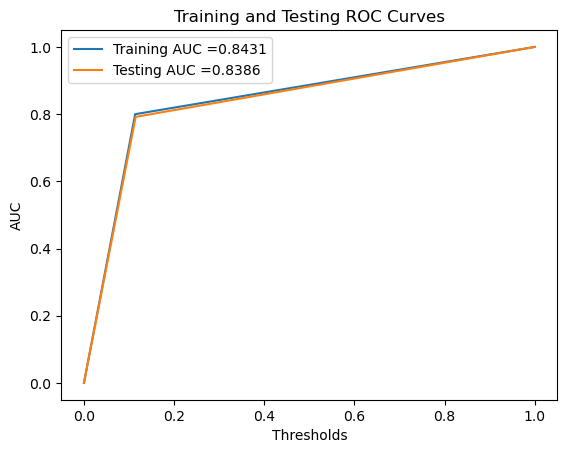

In [25]:
plt.plot(train_fpr_2, train_tpr_2, label = "Training AUC ="+str(round(auc(train_fpr_2, train_tpr_2),4)))
plt.plot(test_fpr_2, test_tpr_2, label = "Testing AUC ="+str(round(auc(test_fpr_2, test_tpr_2),4)))
plt.legend()
plt.xlabel("Thresholds")
plt.ylabel("AUC")
plt.title("Training and Testing ROC Curves")
plt.show()

## Plotting Confusion Matrix - NB with BOW

The confusion matrix is a fundamental tool in assessing the performance of classification models. It provides a detailed breakdown of the predicted and actual classes, allowing us to analyze the model's behavior and identify areas for improvement.

The confusion matrix is a square matrix where rows correspond to the actual classes, and columns correspond to the predicted classes. Each cell in the matrix represents the number of instances that were classified into a particular combination of actual and predicted classes.

- **True Positives (TP):** Instances where the model correctly predicts the positive class.
- **True Negatives (TN):** Instances where the model correctly predicts the negative class.
- **False Positives (FP):** Instances where the model incorrectly predicts the positive class (Type I error).
- **False Negatives (FN):** Instances where the model incorrectly predicts the negative class (Type II error).

By examining these four metrics, we gain insight into the model's performance across different classes and can assess its ability to discriminate between them.

Typically, the confusion matrix is presented as a heatmap, with each cell color-coded to indicate the number of instances. This visualization allows for quick interpretation of the model's performance, highlighting areas of high accuracy and potential misclassification.

Confusion matrices serve as a cornerstone in assessing the efficacy of our classification model. By analyzing their components and visualizing the results, we can make informed decisions regarding model refinement and optimization, ultimately enhancing their predictive capabilities.

<Axes: >

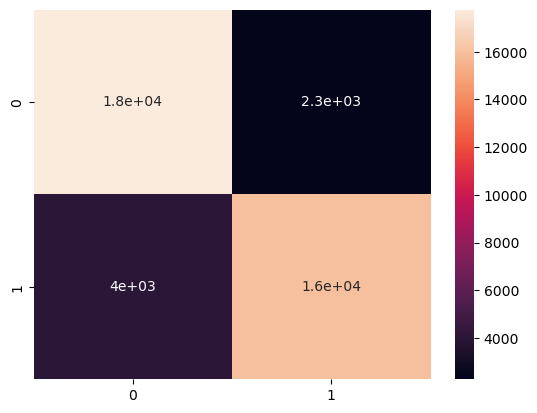

In [26]:
# Convert predicted probabilities to binary predictions using a threshold
threshold = 0.5 
predicted_probs = np.array(nb.posterior(X_train_bow2))
y_pred_binary_train2 = np.where(predicted_probs > threshold, 1, 0)

# Compute confusion matrix
conf_matrix_train2 = confusion_matrix(y_train2, y_pred_binary_train2)

# Visualize confusion matrix
sns.heatmap(conf_matrix_train2, annot=True)

<Axes: >

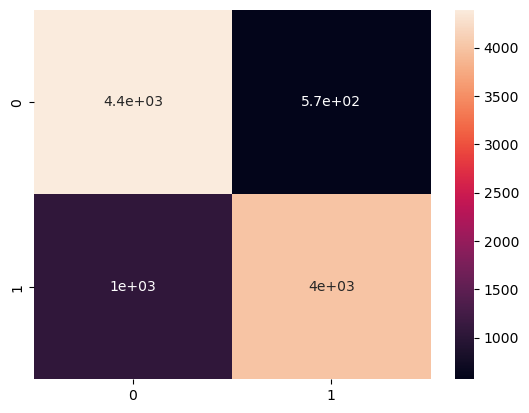

In [27]:
# Convert predicted probabilities to binary predictions using a threshold
threshold = 0.5 
predicted_probs = np.array(nb.posterior(X_test_bow2))
y_pred_binary_test2 = np.where(predicted_probs > threshold, 1, 0)

# Compute confusion matrix
conf_matrix_test2 = confusion_matrix(y_test2, y_pred_binary_test2)

# Visualize confusion matrix
sns.heatmap(conf_matrix_test2, annot=True)

## Multinomial Naive Bayes Implementation Using Sklearn

In [28]:
sklearn_model = MultinomialNB().fit(X_train_bow,y_train)

In [29]:
# prediction
y_pred_sk = sklearn_model.predict(X_test_bow)

In [30]:
score = accuracy_score(y_test,y_pred_sk)
print("accuracy_score = " + str('{:04.2f}'.format(score*100))+" %")
print(classification_report(y_test,y_pred_sk))

accuracy_score = 84.19 %
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      4961
           1       0.84      0.84      0.84      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



## Plotting ROC Curve - sklearn

ROC - Receiver operating characteristic curve

AUC - Area under the ROC Curve

In [31]:
train_fpr_sk, train_tpr_sk, thresholds = roc_curve(y_train, sklearn_model.predict_proba(X_train_bow)[:, 1])
test_fpr_sk, test_tpr_sk, thresholds = roc_curve(y_test, sklearn_model.predict_proba(X_test_bow)[:, 1])

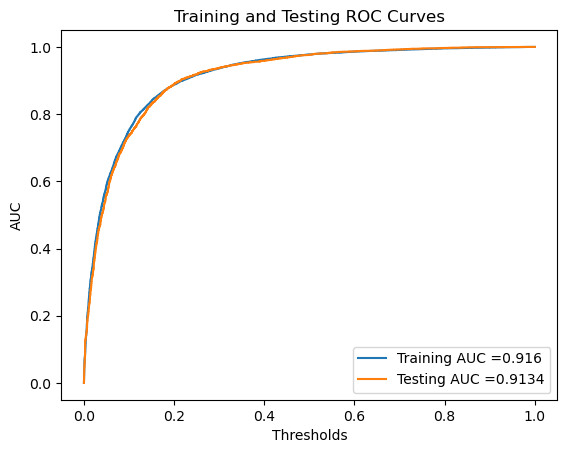

In [32]:
plt.plot(train_fpr_sk, train_tpr_sk, label = "Training AUC ="+str(round(auc(train_fpr_sk, train_tpr_sk),4)))
plt.plot(test_fpr_sk, test_tpr_sk, label = "Testing AUC ="+str(round(auc(test_fpr_sk, test_tpr_sk),4)))
plt.legend()
plt.xlabel("Thresholds")
plt.ylabel("AUC")
plt.title("Training and Testing ROC Curves")
plt.show()

## Plotting Confusion Matrix - sklearn

<Axes: >

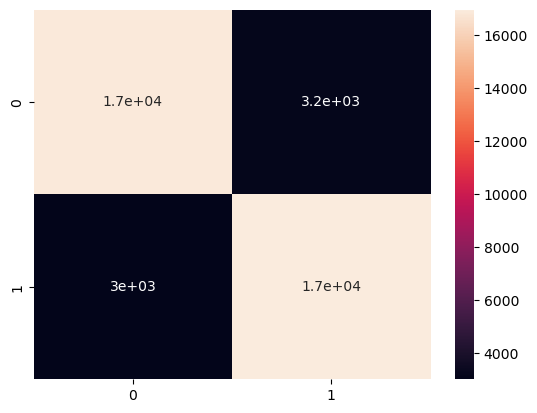

In [33]:
# Convert predicted probabilities to binary predictions using a threshold
threshold = 0.5 
y_pred_binary_train = np.where(sklearn_model.predict_proba(X_train_bow)[:, 1] > threshold, 1, 0)

# Compute confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_binary_train)

# Visualize confusion matrix
sns.heatmap(conf_matrix_train, annot=True)

<Axes: >

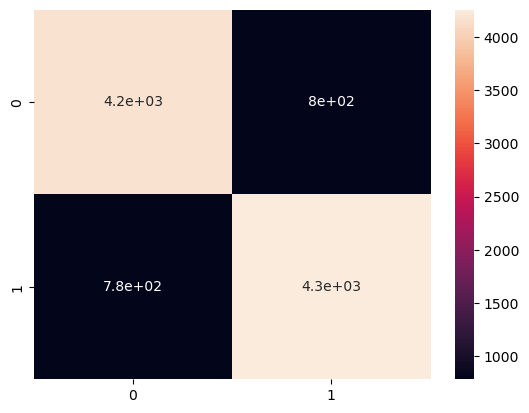

In [34]:
# Convert predicted probabilities to binary predictions using a threshold
threshold = 0.5 
y_pred_binary_test = np.where(sklearn_model.predict_proba(X_test_bow)[:, 1] > threshold, 1, 0)

# Compute confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_pred_binary_test)

# Visualize confusion matrix
sns.heatmap(conf_matrix_test, annot=True)